In [4]:
%run setup.py

In [5]:
stars = pd.read_csv('../sample/samples_rg.csv')
vrard = pd.read_csv('../sample/vrard+16.csv')
stars = stars.merge(vrard[['KIC', 'DPi1', 'e_DPi1']], on='KIC', how='left')

idx = stars['DPi1'].notna() & stars['e_DPi1'].notna()
stars = stars[idx].reset_index(drop=True)

stars = stars.loc[idx,:].reset_index(drop=True)
modes = pd.read_csv('../sample/modes_rg.csv')

# parameters inference

In [6]:
sufs = ['_ma18', '_ma22',  '_ma18_wt', '_ma22_wt',
        '_mf0.005', '_mf0.015', 
        '_mY0.25', '_mY0.30',  '_mY0.25_wt', '_mY0.30_wt',
        '_mZX0.0181', '_mZX0.0274', 
        '_ma18_x5', '_ma22_x5', 
        '_ma18_x2', '_ma22_x2', '_m']

# '_mZ0.01', '_mZ0.02', 
# labels = [r'$\alpha_{\rm MLT} = 1.8$', 
#           r'$\alpha_{\rm MLT} = 2.2$', 
#           r'$\f_{\rm ov, core} = 0.005$',
#           r'$\f_{\rm ov, core} = 0.015$',
#           r'$Y_{\rm init} = 0.25$',
#           r'$Y_{\rm init} = 0.30$',
#           r'$Z_{\rm init} = 0.01$',
#           r'$Z_{\rm init} = 0.02$',
#           r'$\nu_{l=0}$, $\nu_{l=2}$, $\Delta\Pi_1$, $L$, $\nu_{\rm max}$']

original_cols = ['star_mass', 'radius',  'star_age', 'Yinit', 'Zinit', 'Xinit', 'amlt', 
                 'fov_core', 'fov_shell', 'Teff', 'luminosity', 'FeH', 'numax_scaling']
to_append_cols = [t for suf in sufs for t in ['mass'+suf, 'radius'+suf, 'age'+suf, 'Yinit'+suf, 'Zinit'+suf, 'Xinit'+suf, 'amlt'+suf, 
                                              'fov_core'+suf, 'fov_shell'+suf, 'Teff'+suf, 'luminosity'+suf, 'FeH'+suf, 'numax'+suf] ]
to_append_e_cols = [t for t in ['e_'+col for col in to_append_cols] ]
to_append_other = ['chi2_seismic_min', 'chi2_all_min', 'Nmodels_chi2_seismic', 'Nmodels_chi2_all']

keys = ['star_mass', 'radius',  'star_age', 'Yinit', 'Zinit', 'amlt', 
        'fov_core', 'fov_shell', 'Teff', 'luminosity', 'FeH', 'numax_scaling', 
        'Dnu_freq', 'delta_Pg', 'chi2_seismic_l0', 'chi2_seismic_l2', 'chi2']

def multi(inputs):
    istar, star = inputs
    filepath = rootpath+'numax/results_gaia_nu_sc/{:0.0f}/data.h5'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]*(len(to_append_cols) + len(to_append_e_cols) + len(to_append_other))

    data = h5py.File(filepath, 'r')
    data = pd.DataFrame({key:data[key][:] for key in keys})
    data['Xinit'] = 1-data['Yinit']-data['Zinit']

    chi2_Teff = (data['Teff']-star['Teff'])**2.0 / star['e_Teff']**2.0
    chi2_mh = (data['FeH']-star['[M/H]'])**2.0 / star['e_[M/H]']**2.0
    chi2_lum = (data['luminosity']-star['luminosity'])**2.0 / star['e_luminosity']**2.0
    chi2_numax = (data['numax_scaling']-star['numax'])**2.0 / star['e_numax_yu']**2.0
    # chi2_Dnu = (data['Dnu_freq']-star['Dnu'])**2.0 / star['e_Dnu']**2.0
    chi2_DPi = (data['delta_Pg']-star['DPi1'])**2.0 / star['e_DPi1']**2.0

    chi2_amlt_18 = (data['amlt']-1.8)**2.0 / 0.1**2.0
    chi2_amlt_22 = (data['amlt']-2.2)**2.0 / 0.1**2.0
    chi2_fovc_0005 = (data['fov_core']-0.005)**2.0 / 0.005**2.0
    chi2_fovc_0015 = (data['fov_core']-0.015)**2.0 / 0.005**2.0
    chi2_fovs_0002 = (data['fov_shell']-0.002)**2.0 / 0.002**2.0
    chi2_fovs_0005 = (data['fov_shell']-0.005)**2.0 / 0.002**2.0
    chi2_Y_025 = (data['Yinit']-0.25)**2.0 / 0.03**2.0
    chi2_Y_030 = (data['Yinit']-0.30)**2.0 / 0.03**2.0
    # chi2_Z001 = (data['Zinit']-0.01)**2.0 / 0.005**2.0
    # chi2_Z002 = (data['Zinit']-0.02)**2.0 / 0.005**2.0
    chi2_ZX_00181 = (data['FeH']-star['[M/H]'])**2.0 / star['e_[M/H]']**2.0
    chi2_ZX_00274 = ((data['FeH'] + np.log10(0.0181) - np.log10(0.0274))-star['[M/H]'])**2.0 / star['e_[M/H]']**2.0

    chi2_all = (data['chi2_seismic_l0'] + data['chi2_seismic_l2'] + chi2_lum  + chi2_Teff + chi2_mh + chi2_numax + chi2_DPi)
    chi2_all_wot = (data['chi2_seismic_l0'] + data['chi2_seismic_l2'] + chi2_lum + chi2_mh + chi2_numax + chi2_DPi)
    
    chi2_seismic_min = np.min(data['chi2_seismic_l0'] + data['chi2_seismic_l2'])
    chi2_all_min = np.min(chi2_all)
    Nmodels_chi2_seismic = np.sum((data['chi2_seismic_l0'] + data['chi2_seismic_l2']) < 25)
    Nmodels_chi2_all = np.sum((chi2_all) < 25)

    scale = 1 # 1/5 # 1
    chi2_1 = chi2_all*scale + chi2_amlt_18
    chi2_2 = chi2_all*scale + chi2_amlt_22
    chi2_1p = chi2_all_wot*scale + chi2_amlt_18
    chi2_2p = chi2_all_wot*scale + chi2_amlt_22
    chi2_3 = chi2_all*scale + chi2_fovc_0005
    chi2_4 = chi2_all*scale + chi2_fovc_0015
    chi2_5 = chi2_all*scale + chi2_Y_025
    chi2_6 = chi2_all*scale + chi2_Y_030
    chi2_5p = chi2_all_wot*scale + chi2_Y_025
    chi2_6p = chi2_all_wot*scale + chi2_Y_030
    # chi2_7 = chi2_all*scale + chi2_Z_001
    # chi2_8 = chi2_all*scale + chi2_Z_002
    chi2_7 = chi2_all*scale - chi2_mh*scale + chi2_ZX_00181
    chi2_8 = chi2_all*scale - chi2_mh*scale+ chi2_ZX_00274

    chi2_9 = chi2_all/5 + chi2_amlt_18
    chi2_10 = chi2_all/5 + chi2_amlt_22
    chi2_11 = chi2_all/2 + chi2_amlt_18
    chi2_12 = chi2_all/2 + chi2_amlt_22

    vars, e_vars = [], []
    for chi2 in [chi2_1, chi2_2, chi2_1p, chi2_2p, chi2_3, chi2_4, chi2_5, chi2_6, chi2_5p, chi2_6p, chi2_7, chi2_8, chi2_9, chi2_10, chi2_11, chi2_12, chi2_all]:
        results = quantile(np.array([data[col].to_numpy() for col in original_cols]).T, (0.16, 0.5, 0.84), weights=np.exp(-chi2/2.))
        # vars.append(list(results[1,:]))
        vars.append(list(np.average(np.array([data[col].to_numpy() for col in original_cols]).T, weights=np.exp(-chi2/2.), axis=0)))
        e_vars.append(list((results[2,:] - results[0,:])/2.))
    vars = [tt for t in vars for tt in t]
    e_vars = [tt for t in e_vars for tt in t]

    return vars + e_vars + [chi2_seismic_min, chi2_all_min, Nmodels_chi2_seismic, Nmodels_chi2_all]

r = list(tqdm(get_context("fork").Pool(8).imap(multi, stars.loc[:].iterrows()), total=len(stars), position=0))
stars.loc[:, to_append_cols + to_append_e_cols + to_append_other]  = np.array(r)

100%|██████████| 341/341 [01:06<00:00,  5.16it/s]


In [11]:
# params = pd.read_csv('../../hpc/coarse_v5/template/coarse_grid_input_params_v5.txt', sep=', ')
# params.describe()

In [28]:
# data = np.array([stars['age_ma18']-stars['age_ma22'], 
#                  stars['amlt_ma18']-stars['amlt_ma22'],
#                  stars['Zinit_ma18']-stars['Zinit_ma22'], 
#                  stars['Xinit_ma18']-stars['Xinit_ma22'], 
#                  stars['Yinit_ma18']-stars['Yinit_ma22']]).T
# idx = data[:,0] > -0.4e10
# data = data[idx,:]
# fig = corner.corner(data, labels=['dage', 'damlt', 'dZ', 'dX', 'dY'], color='C1');


# data = np.array([stars['age_mY0.25']-stars['age_mY0.30'], 
#                  stars['amlt_mY0.25']-stars['amlt_mY0.30'],
#                  stars['Zinit_mY0.25']-stars['Zinit_mY0.30'], 
#                  stars['Xinit_mY0.25']-stars['Xinit_mY0.30'], 
#                  stars['Yinit_mY0.25']-stars['Yinit_mY0.30']]).T
# idx = data[:,0] > -0.4e10
# data = data[idx,:]
# corner.corner(data, labels=['dage', 'damlt', 'dZ', 'dX', 'dY'], fig=fig, color='C2');

# Figure

<>:74: SyntaxWarning: invalid escape sequence '\%'
<>:74: SyntaxWarning: invalid escape sequence '\%'
/var/folders/gb/6_82rvxx7s10tm5lg6kjpb6w0000gn/T/ipykernel_6369/936606901.py:74: SyntaxWarning: invalid escape sequence '\%'
  axes[2].text(0.03, 0.85 -0.15*isuf, r'$\Delta {\rm Age}$'+' = {:.1f} \%'.format(stars['age'+suf].median()), color=colors[isuf], transform=axes[2].transAxes, fontsize=fontsize-1.6)


Text(0.5, 0, 'Fractional difference in age (\\%)')

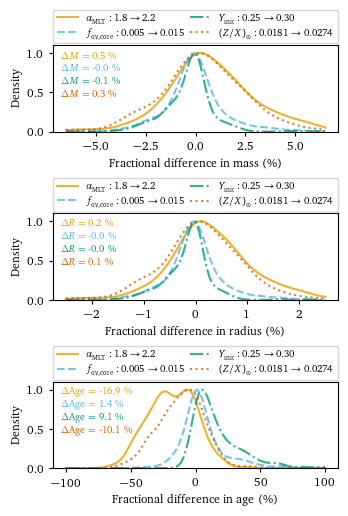

In [5]:
sufs = ['_ma18', '_ma22', '_mf0.005', '_mf0.015', '_mY0.25', '_mY0.30', '_mZX0.0181', '_mZX0.0274',  '_m']
labels = [r'$\alpha_{\rm MLT} = 1.8$', 
          r'$\alpha_{\rm MLT} = 2.2$', 
          r'$\f_{\rm ov, core} = 0.005$',
          r'$\f_{\rm ov, core} = 0.015$',
          r'$Y_{\rm init} = 0.25$',
          r'$Y_{\rm init} = 0.30$',
          r'$(Z/X)_{\odot} = 0.0181$',
          r'$(Z/X)_{\odot} = 0.0274$',
          r'$\nu_{l=0}$, $\nu_{l=2}$, $\Delta\Pi_1$, $L$, $\nu_{\rm max}$']

original_cols = ['star_mass', 'radius',  'star_age', 'Yinit', 'Zinit', 'Xinit', 'amlt', 
                 'fov_core', 'fov_shell', 'Teff', 'luminosity', 'FeH']
to_append_cols = [t for suf in sufs for t in ['mass'+suf, 'radius'+suf, 'age'+suf, 'Yinit'+suf, 'Zinit'+suf, 'Xinit'+suf, 'amlt'+suf, 
                                              'fov_core'+suf, 'fov_shell'+suf, 'Teff'+suf, 'luminosity'+suf, 'FeH'+suf] ]

sufs_pairs = [['_ma18', '_ma22'], ['_mf0.005', '_mf0.015'], ['_mY0.25', '_mY0.30'], ['_mZX0.0181', '_mZX0.0274']]
new_sufs = ['_da', '_df', '_dY', '_dZ']
new_labels = [r'$\alpha_{\rm MLT}: 1.8 \rightarrow 2.2$', 
          r'$f_{\rm ov, core}: 0.005 \rightarrow 0.015$',
          r'$Y_{\rm init}: 0.25 \rightarrow 0.30$',
          r'$(Z/X)_{\odot}: 0.0181 \rightarrow 0.0274$']

for isuf, [suf1, suf2] in enumerate(sufs_pairs):
    for var in ['mass', 'radius', 'age']:
        # stars[var+new_sufs[isuf]] = np.abs((stars[var+suf1] / stars[var+suf2] - 1)*100)
        stars[var+new_sufs[isuf]] = (stars[var+suf1] / stars[var+suf2] - 1)*100
        # print(var+new_sufs[isuf], '{:.1f}'.format(np.mean(stars[var+new_sufs[isuf]])))


# remove those with error bars too small such that the grid resolution is not sufficient
# these stars are simply likely to have unrealistically small error bars
# idx = stars['age_da'].notna() # (stars['age_da']>0.001) 
coeffs = np.polyfit(np.log(stars['Dnu']), np.log(stars['DPi1']), 2)
idx = (((stars['luminosity'] - stars['luminosity_ma18']) / stars['e_luminosity']).abs() < 4.) \
    & (((stars['numax'] - stars['numax_ma18']) / stars['e_numax']).abs() < 4. ) \
    & (((stars['[M/H]'] - stars['FeH_ma18']) / stars['e_[M/H]']).abs() < 4. ) \
    & (((stars['Teff'] - stars['Teff_ma18']) / stars['e_Teff']).abs() < 4. ) \
    & ( ( np.abs(stars['DPi1'] / np.exp(np.polyval(coeffs, np.log(stars['Dnu']))) - 1) ) < 0.06 ) \
    & stars['age_da'].notna()

sample = stars[idx]

fig, axes = plt.subplots(figsize=figsize(column='one', ratio=3*0.5), nrows=3, ncols=1, squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

markers = ['o', '^', 's', 'v', '>', '<']

for isuf, suf in enumerate(new_sufs[:]):
    styles = {'linestyle': linestyles[isuf], 'color':colors[isuf], 'alpha':0.8} #'capsize':2,  'ms':5, 'marker':markers[isuf], 

    kernel = scipy.stats.gaussian_kde(sample['mass'+suf])
    # x = np.linspace(0, 12, 100); 
    x = np.linspace(-6.5, 6.5, 100); 
    y = kernel(x); y /= np.max(y);
    axes[0].plot(x, y, label=new_labels[isuf], **styles)

    kernel = scipy.stats.gaussian_kde(sample['radius'+suf])
    # x = np.linspace(0, 4, 100);
    x = np.linspace(-2.5, 2.5, 100);
    y = kernel(x); y /= np.max(y);
    axes[1].plot(x, y, label=new_labels[isuf], **styles)

    kernel = scipy.stats.gaussian_kde(sample['age'+suf])
    # x = np.linspace(0, 100, 100);
    x = np.linspace(-100, 100, 100);
    y = kernel(x); y /= np.max(y);
    axes[2].plot(x, y, label=new_labels[isuf], **styles)

    # for var in ['mass', 'radius', 'age']:
    #     print(var+suf, '{:.1f}'.format(stars[var+suf].median()))
    axes[0].text(0.03, 0.85 -0.15*isuf, r'$\Delta M$ = {:.1f} \%'.format(stars['mass'+suf].median()), color=colors[isuf], transform=axes[0].transAxes, fontsize=fontsize-1.6)
    axes[1].text(0.03, 0.85 -0.15*isuf, r'$\Delta R$ = {:.1f} \%'.format(stars['radius'+suf].median()), color=colors[isuf], transform=axes[1].transAxes, fontsize=fontsize-1.6)
    axes[2].text(0.03, 0.85 -0.15*isuf, r'$\Delta {\rm Age}$'+' = {:.1f} \%'.format(stars['age'+suf].median()), color=colors[isuf], transform=axes[2].transAxes, fontsize=fontsize-1.6)


for iax in range(3):
    axes[iax].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                        ncols=2, mode="expand", borderaxespad=0., fontsize=fontsize-1.6)
    axes[iax].set_ylim(0, 1.1)
    axes[iax].set_ylabel('Density')


axes[0].set_xlabel(r'Fractional difference in mass ' + '(\\%)')
axes[1].set_xlabel(r'Fractional difference in radius ' + '(\\%)')
axes[2].set_xlabel(r'Fractional difference in age ' + '(\\%)')


# filename = 'Fig.2_sys_diff.pdf'
# plt.savefig(filename, dpi=300)
# os.system(to_overleaf(filename))